In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm
import copy
from hessian import *
from system import *

import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)

# Dimer

In [2]:
dimer_wavenumbers = get_wavenumbers("dimer_normal_modes.molden")
dimer_frequencies = wavenumber_to_frequency(dimer_wavenumbers)

In [3]:
n_atoms = 280
n_modes = 3 * n_atoms - 6

Mg1_index = 0
Mg2_index = 140

all_displacements = get_all_displacements("dimer_normal_modes.molden", n_atoms, n_modes)
rel_displacements = get_all_rel_displacements("dimer_normal_modes.molden", n_atoms, n_modes, 0, 140)

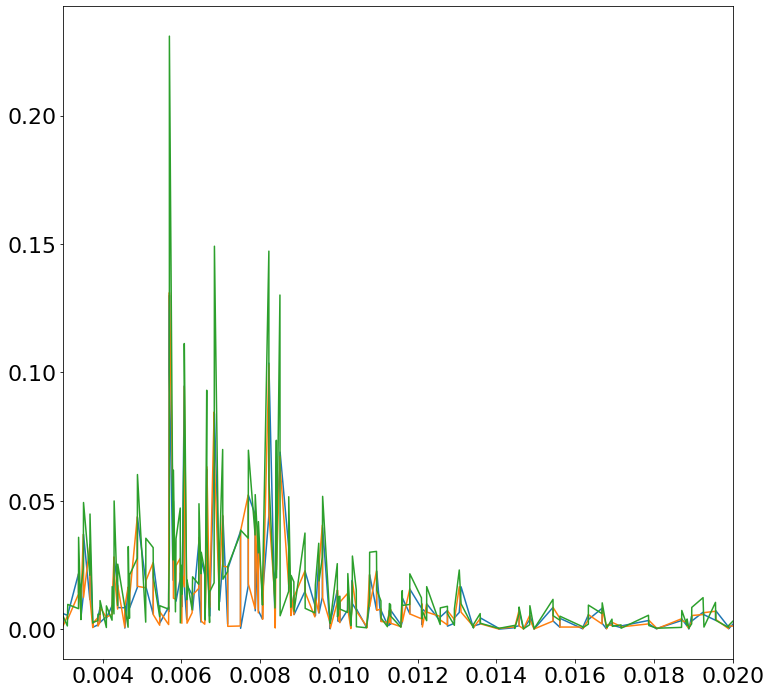

In [4]:
fig, ax = plt.subplots()

positive_freqs = np.where(dimer_frequencies > 0)[0]

ax.plot(dimer_frequencies[positive_freqs], all_displacements[Mg1_index][positive_freqs])
ax.plot(dimer_frequencies[positive_freqs], all_displacements[Mg2_index][positive_freqs])
ax.plot(dimer_frequencies[positive_freqs], rel_displacements[positive_freqs])

ax.set_xlim(3e-3, 2e-2)

fig.set_size_inches(12,12)

In [5]:
sorting_indicies = np.argsort(np.tile(dimer_frequencies, 2))

np.save("dimer_hess_frequencies", np.tile(dimer_frequencies, 2)[sorting_indicies])
np.save("dimer_hess_displacements", np.concatenate((all_displacements[Mg1_index], all_displacements[Mg2_index]))[sorting_indicies])

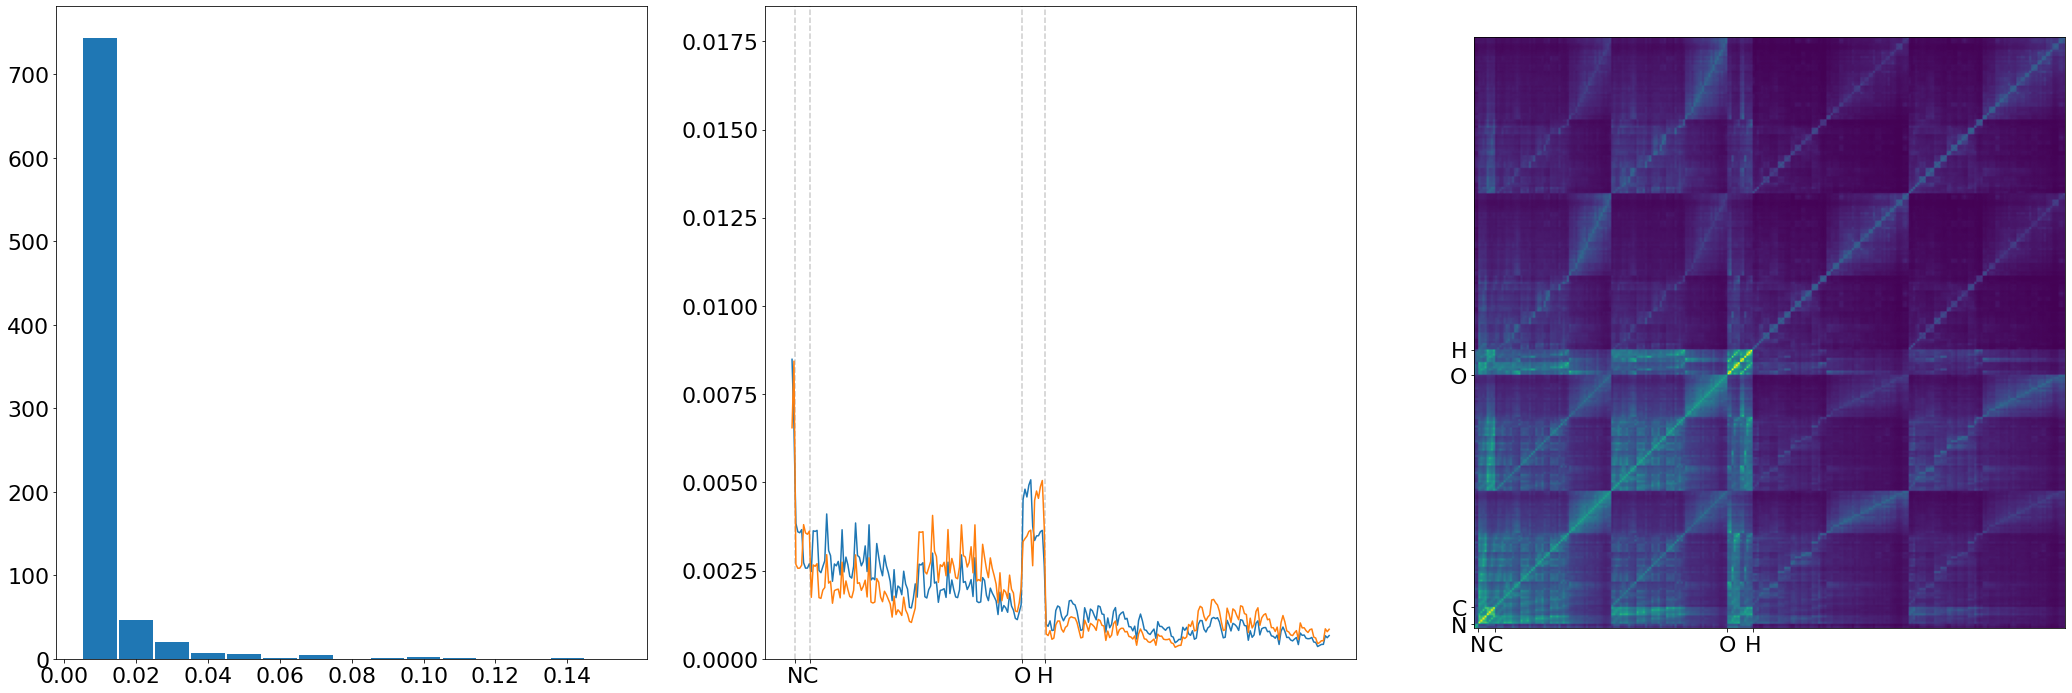

In [8]:
fig, ax = plt.subplots(1, 3)

symbols = read_symbols("dimer.xyz")

Mg_indices = np.array([enum for enum, x in enumerate(symbols) if x == "Mg"])
N_indices = np.array([enum for enum, x in enumerate(symbols) if x == "N"])
C_indices = np.array([enum for enum, x in enumerate(symbols) if x == "C"])
O_indices = np.array([enum for enum, x in enumerate(symbols) if x == "O"])
H_indices = np.array([enum for enum, x in enumerate(symbols) if x == "H"])

Mg_avg_disp= all_displacements[Mg_indices].max()
N_avg_disp = all_displacements[N_indices].max()
C_avg_disp = all_displacements[C_indices].max()
O_avg_disp = all_displacements[O_indices].max()
H_avg_disp = all_displacements[H_indices].max()

normalized_displacements = copy.copy(all_displacements)

normalized_displacements[Mg_indices] /= Mg_avg_disp
normalized_displacements[N_indices] /= N_avg_disp
normalized_displacements[C_indices] /= C_avg_disp
normalized_displacements[O_indices] /= O_avg_disp
normalized_displacements[H_indices] /= H_avg_disp

grouped_symbols = np.concatenate((Mg_indices, N_indices, C_indices, O_indices, H_indices))

normalized_displacements = normalized_displacements[grouped_symbols]

bins = np.linspace(0, 0.15, 16)
his = np.histogram(all_displacements[Mg1_index], bins=bins)

ax[0].bar(his[1][1:], his[0], width=0.15/len(bins), align='center')
ax[0].set_xticks(bins[::2])

Mg_displacements = np.where(all_displacements[Mg1_index] > 0.0)[0]

correlation = np.zeros((n_atoms, n_atoms))

for i in Mg_displacements:
    correlation += np.outer(normalized_displacements[:,i], normalized_displacements[:,i])
    
correlation /= len(Mg_displacements)

cax = ax[2].imshow(correlation, origin='lower', cmap=plt.get_cmap('viridis'))#, norm=LogNorm(vmin=0.0001, vmax=20))
    
#fig.colorbar(cax)

# number of each element --  Mg: 2, N: 8, C: 68, O: 8, H: 72
# cumulative -- 2, 10, 78, 86, 158

def ticks(symbols):
    Mg_indices= get_indices(symbols, "Mg")
    N_indices = get_indices(symbols, "N")
    C_indices = get_indices(symbols, "C")
    O_indices = get_indices(symbols, "O")
    H_indices = get_indices(symbols, "H")
    
    lengths = [len(Mg_indices), len(N_indices), len(C_indices), len(O_indices), len(H_indices)]
    
    cumulative = np.cumsum(lengths)
    
    ticks = np.array([x - 0.5 for x in cumulative[:-1]])
    
    return ticks

# number of each element --  Mg: 1, N: 4, C: 55, O: 6, H: 74
# cumulative -- 1, 5, 39, 43, 79

symbol_ticks = ticks(symbols)
symbol_labels= ["N","C","O","H"]

ax[2].set_xticks(symbol_ticks)
ax[2].set_xticklabels(symbol_labels)

ax[2].set_yticks(symbol_ticks)
ax[2].set_yticklabels(symbol_labels)

ax[1].plot(correlation[0])
ax[1].plot(correlation[1])
ax[1].set_xticks(symbol_ticks)
ax[1].set_xticklabels(symbol_labels)

ax[1].vlines(symbol_ticks, color='black', linestyle='--', ymin=0, ymax=max(correlation[0])+0.01, alpha=0.2)
ax[1].set_ylim(0, max(correlation[0])+0.01)

fig.set_size_inches(36,12)

## Chlorophyll-seperation force constant

In [9]:
monomer_symbols, _ = read_xyz("opt_bchla.xyz")
monomer_xyz, _ = get_bchla_in_xy_plane()

phytol_link = monomer_xyz[13]
phytol_link_bond = monomer_xyz[13] - monomer_xyz[12]

trunc_mono_symbols = [monomer_symbols[i] for i in range(len(monomer_symbols)) if i not in phytol_indices()]
trunc_mono_xyz = [monomer_xyz[i] for i in range(len(monomer_xyz)) if i not in phytol_indices()]

trunc_mono_symbols.append("H")
trunc_mono_xyz.append(1.1073 * phytol_link_bond/np.linalg.norm(phytol_link_bond) + monomer_xyz[12])

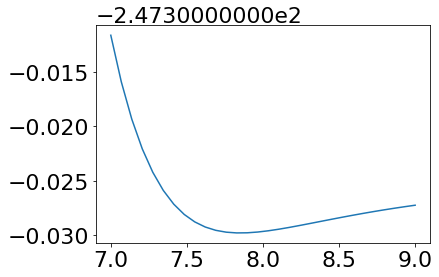

In [60]:
import subprocess
import json

def run_qcore(qcore_str):
    #qcore_path = os.environ["QCORE_PATH"]
    qcore_path="~/qcore/cmake-build-release/bin/qcore"
    json_str = " -n 1 -f json --schema none -s "
    
    json_run = subprocess.run(qcore_path + json_str + qcore_str,
                              shell=True,
                              stdout=subprocess.PIPE,
                              executable="/bin/bash",
                              universal_newlines=True)
    
    json_results = json.loads(json_run.stdout)

    return json_results

def write_qcore_xyz(symbols1, symbols2, xyz1, xyz2):
    
    result = "["
    
    for i in range(len(symbols1)):
        result += f"['{symbols1[i]}', {xyz1[i][0]}, {xyz1[i][1]}, {xyz1[i][2]}],"
        
    for i in range(len(symbols2)):
        result += f"['{symbols2[i]}', {xyz2[i][0]}, {xyz2[i][1]}, {xyz2[i][2]}],"
        
    result = result[:-1]
    
    return result + "]"
    
def run_dimer(symbols1, symbols2, xyz1, xyz2):
    
    qcore_str = f"\"res := xtb(structure(xyz = {write_qcore_xyz(symbols1, symbols2, xyz1, xyz2)}))\""
        
    qcore_res = run_qcore(qcore_str)
    
    return qcore_res["res"]["energy"]
    

distances = np.linspace(7, 9, 30)
    
energies = [run_dimer(trunc_mono_symbols, trunc_mono_symbols, trunc_mono_xyz, trunc_mono_xyz + np.array([0, 0, r])) for r in distances]
                                                                                                                                         
plt.plot(distances, energies) 








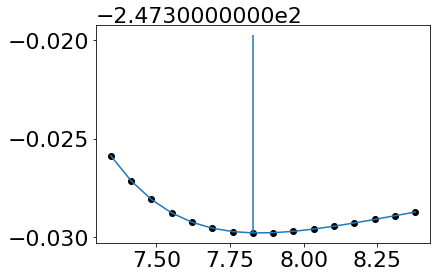

In [66]:
plt.plot(distances[5:21], energies[5:21])
plt.scatter(distances[5:21], energies[5:21], color='black')
plt.vlines([distances[np.argmin(energies)]], ymin=energies[np.argmin(energies)], ymax=energies[np.argmin(energies)]+0.01)